<a href="https://colab.research.google.com/github/fellowship/platform-demos3/blob/master/InteriorDesignClassification/Multi_Label_Interior_Design.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Notebook magic commands
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
#mount google drive in case we need to store data or transfer files

from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# copy the csv file for labels and the dataset folder
import os
os.mkdir('data/')
!cp "drive/My Drive/fellowship/final_data.csv" "data/data.csv"
!cp "drive/My Drive/fellowship/interior_data.tar" "data/"

In [0]:
# Untar the tar file
!tar -zxf data/interior_data.tar -C data/

In [0]:
# Remove the tar file
!rm -rf data/*.tar

In [0]:
import fastai
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
print(fastai.__version__)

1.0.52


In [0]:
from pathlib import Path
path = Path('data')
imagepath = Path('data/train_images')
dataset = get_image_files(imagepath)
print(len(dataset))

20097


In [0]:
df = pd.read_csv(path/'data.csv')
df.head()

,images,class
0,img0.jpg,"Classic, Traditional"
1,img1.jpg,"Modern, Bohemian, Glam"
2,img2.jpg,"Modern, Bohemian, Glam"
3,img3.jpg,"Farmhouse, Transitional"
4,img4.jpg,Transitional


In [0]:
tfms = get_transforms(max_warp=0.)

In [0]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'data.csv', folder='train_images')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=','))

In [0]:
data = (src.transform(tfms, size=128)
        .databunch(bs=128).normalize(imagenet_stats))

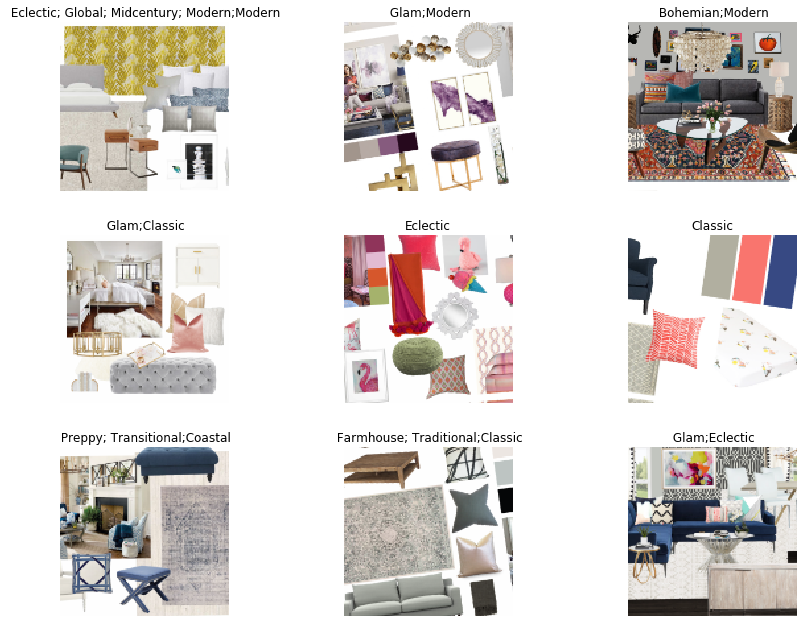

In [0]:
data.show_batch(rows=3, figsize=(12,9))

In [0]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
#f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, models.resnet18, metrics=acc_02)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:04<00:00, 10724690.15it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


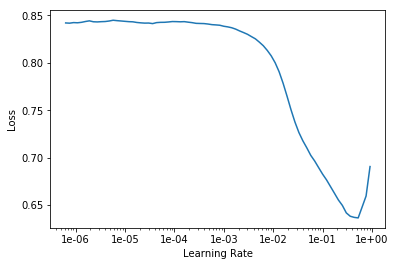

In [0]:
# Freeze the model and plot the Loss- Lr curve
learn.freeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.264631,0.203930,0.899936,39:01
1,0.206282,0.196847,0.908217,39:05


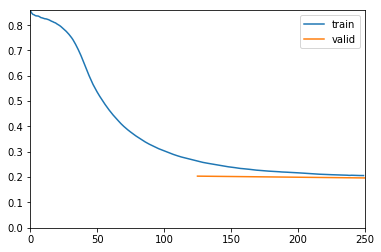

Better model found at epoch 0 with accuracy_thresh value: 0.8999362587928772.
Better model found at epoch 1 with accuracy_thresh value: 0.908217191696167.


In [0]:
# Training the model for 10 epochs
learn.fit_one_cycle(2, max_lr=1e-02, callbacks=[ShowGraph(learn), SaveModelCallback(learn, mode='max', every='improvement', monitor='accuracy_thresh', name='stage1')])